In [1]:
from findspark import init
init()

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions  as sf

spark = SparkSession.builder.master('yarn').appName('lab5').getOrCreate()


In [3]:
sc = spark.sparkContext

import pandas as pd
import numpy as np
from pandas import DataFrame

df_mise = spark.read.option('header','true')\
    .option('nullValue','?')\
    .option('inferSchema','true')\
    .csv('s3://ssds2/mise04.csv')


mise = df_mise.toPandas()




In [5]:
mise.head(5)

,구,2018-04-01,2018-04-02,2018-04-03,2018-04-04,2018-04-05,2018-04-06,2018-04-07,2018-04-08,2018-04-09,2018-04-10,2018-04-11,2018-04-12,2018-04-13,2018-04-14,2018-04-15,2018-04-16,2018-04-17,2018-04-18,2018-04-19,2018-04-20,2018-04-21,2018-04-22,2018-04-23,2018-04-24,2018-04-25,2018-04-26,2018-04-27,2018-04-28,2018-04-29,2018-04-30
0,종로구,27,24,17,5,4,21,20,13,22,18,20,14,13,11,17,20,25,27,34,46,35,18,6,4,22.0,26,34,34,28,47
1,중구,28,22,16,6,5,19,19,12,24,18,18,13,13,11,18,19,25,27,35,47,36,18,6,5,21.0,27,36,36,29,50
2,용산구,40,33,25,8,4,32,26,17,29,21,24,14,12,10,20,21,31,36,40,59,43,20,5,4,26.0,30,42,42,34,58
3,성동구,43,35,26,9,6,30,27,17,23,21,30,17,18,15,25,27,37,39,45,64,51,27,8,4,NaN,38,42,44,38,69
4,광진구,31,24,18,6,4,21,21,13,21,18,21,13,13,11,20,20,27,32,35,47,38,18,5,5,22.0,27,34,38,29,50


In [6]:
mise2 = mise.set_index('구').fillna(mise.median())
mise2.head(5)

,2018-04-01,2018-04-02,2018-04-03,2018-04-04,2018-04-05,2018-04-06,2018-04-07,2018-04-08,2018-04-09,2018-04-10,2018-04-11,2018-04-12,2018-04-13,2018-04-14,2018-04-15,2018-04-16,2018-04-17,2018-04-18,2018-04-19,2018-04-20,2018-04-21,2018-04-22,2018-04-23,2018-04-24,2018-04-25,2018-04-26,2018-04-27,2018-04-28,2018-04-29,2018-04-30
구,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
종로구,27,24,17,5,4,21,20,13,22,18,20,14,13,11,17,20,25,27,34,46,35,18,6,4,22.0,26,34,34,28,47
중구,28,22,16,6,5,19,19,12,24,18,18,13,13,11,18,19,25,27,35,47,36,18,6,5,21.0,27,36,36,29,50
용산구,40,33,25,8,4,32,26,17,29,21,24,14,12,10,20,21,31,36,40,59,43,20,5,4,26.0,30,42,42,34,58
성동구,43,35,26,9,6,30,27,17,23,21,30,17,18,15,25,27,37,39,45,64,51,27,8,4,23.0,38,42,44,38,69
광진구,31,24,18,6,4,21,21,13,21,18,21,13,13,11,20,20,27,32,35,47,38,18,5,5,22.0,27,34,38,29,50


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# mpl.rcParams['axes.unicode_minus'] = False

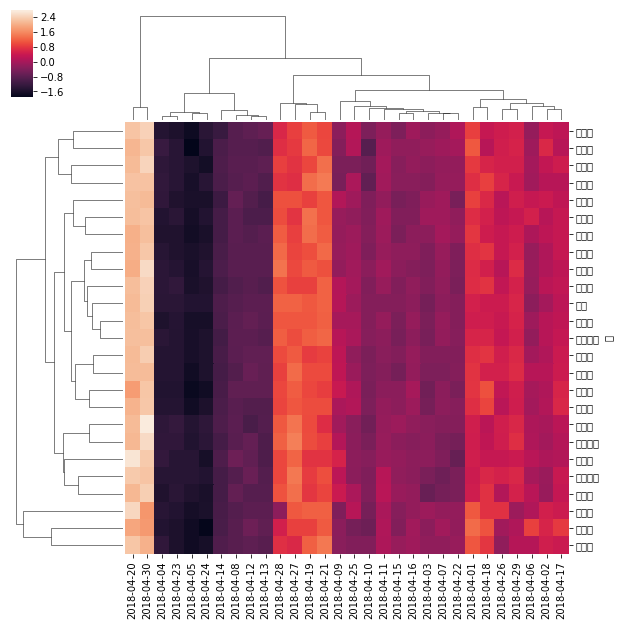

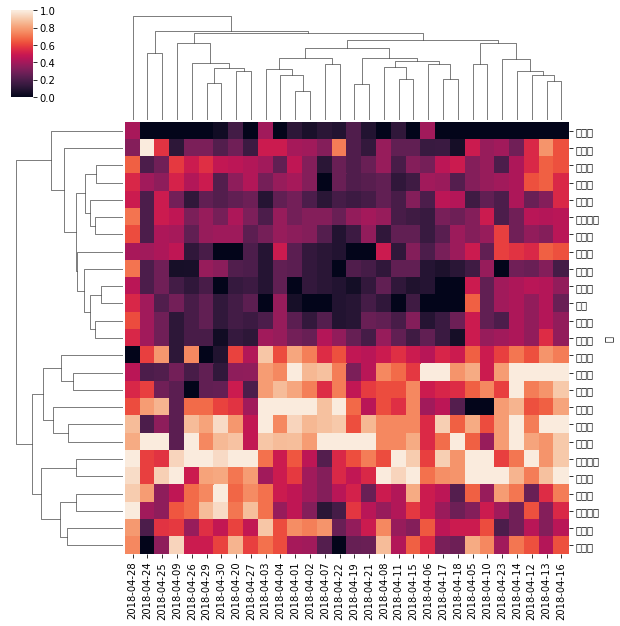

In [8]:
g= sns.clustermap(mise2,z_score=0)
g=sns.clustermap(mise2,standard_scale=1)

### winedata

In [10]:
from pyspark.ml.feature import VectorAssembler
wine = spark.read.option('inferSchema','true')\
            .option('header','true')\
            .csv('s3://ssds2/wine.csv')
wine.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|label|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|          8.9|            0.12|       0.45|           1.8|    0.075|               10.0|                21.0|0.99552|3.41|     0.76|   11.9|      7|    0|
|          5.6|            0.19|       0.46|           1.1|    0.032|               33.0|               115.0| 0.9909|3.36|      0.5|   10.4|      6|    1|
|          6.0|            0.26|       0.32|           3.5|    0.028|               29.0|               113.0| 0.9912| 3.4|     0.71|   12.3|      7|    1|
|          6.2|            0.25|       0.38|           7.9|    0

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler



In [14]:
wine.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- label: integer (nullable = true)



In [17]:
wine2 = wine.drop('label')

In [18]:
wine2.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [21]:
numericOnly = wine.drop('label').dropna().cache()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa556019320>,
      dtype=object)

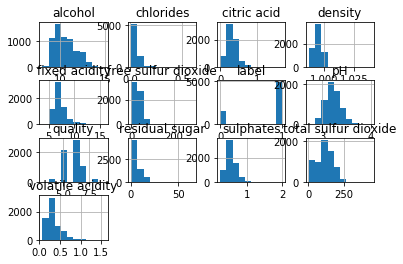

In [22]:
winepd = wine.toPandas()
winepd.hist()

In [58]:

cols = wine.columns
cols.remove('label')
cols.remove('quality')
assembler = VectorAssembler().setInputCols(cols).setOutputCol('features')
wine_assem = assembler.transform(wine)


In [59]:
from pyspark.ml.feature import StandardScaler
assembler = VectorAssembler().setInputCols(cols).setOutputCol('features')
wine_assem = assembler.transform(wine)
standardScaler = StandardScaler().setWithMean(True).setWithStd(True).setInputCol('features').setOutputCol('features_scaled')


In [60]:
from pyspark.ml.feature import PCA


In [61]:
pca = PCA(k=2,inputCol='features_scaled',outputCol='pca_features')
pipeline = Pipeline().setStages([assembler,standardScaler,pca])
pipelineModel = pipeline.fit(wine)
wine_pca = pipelineModel.transform(wine)
wine_pca.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+--------------------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|label|            features|     features_scaled|        pca_features|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+--------------------+--------------------+
|          8.9|            0.12|       0.45|           1.8|    0.075|               10.0|                21.0|0.99552|3.41|     0.76|   11.9|      7|    0|[8.9,0.12,0.45,1....|[1.29948246492746...|[-2.2523965548762...|
|          5.6|            0.19|       0.46|           1.1|    0.032|               33.0|               115.0| 0.9909|3.36| 

In [62]:
from pyspark.sql.functions import udf,col
from pyspark.sql.types import ArrayType,DoubleType

def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_,ArrayType(DoubleType()))(col)

df_wine = wine_pca.withColumn('pca',to_array(col('pca_features'))).select(['label','quality'] + [col('pca')[i] for i in range(2)]).toPandas()

In [63]:
df_wine

,label,quality,pca[0],pca[1]
0,0,7,-2.252397,-0.145140
1,1,6,0.663259,-1.737306
2,1,7,-0.269411,-2.099645
3,1,5,2.409917,0.755805
4,0,5,-2.075416,0.318920
5,1,5,2.882022,2.499697
6,1,7,2.531468,2.554946
7,1,6,0.031634,-1.659722
8,0,6,-1.162043,0.803974
9,0,6,-2.925856,-0.746515


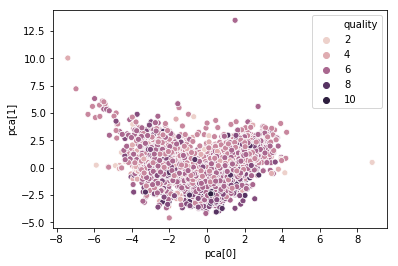

In [64]:
ax = sns.scatterplot(x='pca[0]',y='pca[1]',hue='quality',data=df_wine,c='')

In [31]:
pcaModel = pipelineModel.stages[-1]
pcaModel.explainedVariance.toArray()

array([0.25346226, 0.22082117])

In [32]:
list(zip(pcaModel.pc.toArray(),cols))

[(array([-0.25692873,  0.26184306]), 'fixed acidity'),
 (array([-0.39493118,  0.10519825]), 'volatile acidity'),
 (array([0.14646061, 0.14409348]), 'citric acid'),
 (array([0.31890519, 0.34258497]), 'residual sugar'),
 (array([-0.31344994,  0.2697701 ]), 'chlorides'),
 (array([0.42269137, 0.11117878]), 'free sulfur dioxide'),
 (array([0.47441968, 0.14394753]), 'total sulfur dioxide'),
 (array([-0.09243753,  0.55492047]), 'density'),
 (array([-0.20806957, -0.15292185]), 'pH'),
 (array([-0.29985192,  0.1196342 ]), 'sulphates'),
 (array([-0.05892408, -0.49272747]), 'alcohol'),
 (array([ 0.08747571, -0.29660091]), 'quality')]

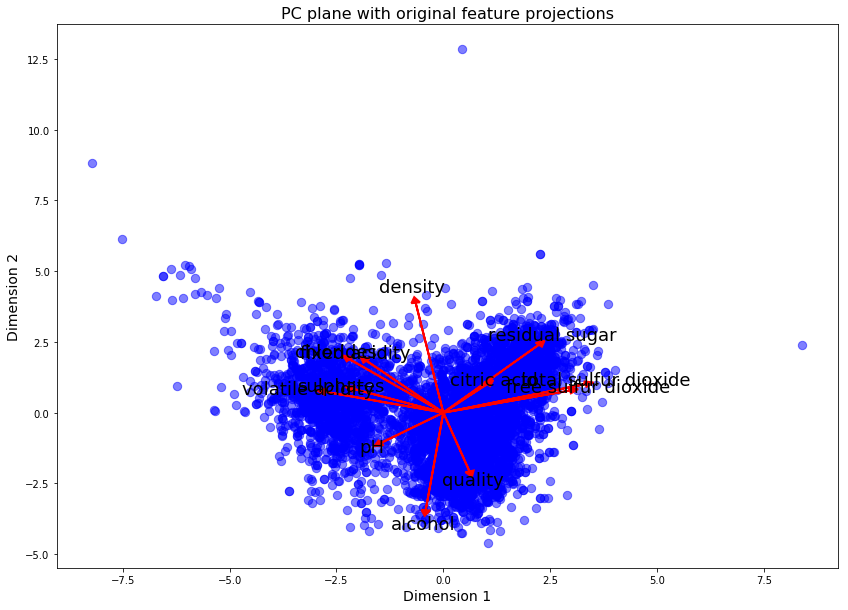

In [37]:
def biplot(data,reduced_data,model):
    fix,ax = plt.subplots(figsize=(14,10))
    ax.scatter(x=reduced_data.loc[:,'pca[0]'],y=reduced_data.loc[:,'pca[1]'],facecolors='b',edgecolors='b',s=70,alpha=0.5)
    feature_vectors = model.pc.toArray()
    arrow_size,text_pos = 7.0,8.0
    for i,v in enumerate(feature_vectors):
        ax.arrow(0,0,arrow_size*v[0],arrow_size*v[1],head_width=0.2,head_length=0.2,linewidth=2,color='red')
        ax.text(v[0]*text_pos,v[1]*text_pos,data.columns[i],color='black',ha='center',va='center',fontsize=18)
        
    ax.set_xlabel('Dimension 1',fontsize=14)
    ax.set_ylabel('Dimension 2',fontsize=14)
    ax.set_title('PC plane with original feature projections',fontsize=16)
    return ax

original_data = wine.toPandas().drop(['label'],axis=1)
biplot(original_data,df_wine,pcaModel)

In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans,KMeansModel
from pyspark.ml.feature import VectorAssembler



In [40]:
wine2.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int32
dtypes: float64(11), int32(1)
memory usage: 583.8 KB


In [42]:
wine2 = wine.cache()
cols = wine2.columns.copy()
cols.remove('label')
assembler = VectorAssembler().setInputCols(cols).setOutputCol('featureVector')
kmeans = KMeans().setPredictionCol('cluster').setFeaturesCol('featureVector')
pipeline = Pipeline().setStages([assembler,kmeans])
pipelineModel = pipeline.fit(wine2)
kmeansModel = pipelineModel.stages[-1]
kmeansModel.clusterCenters()
withCluster = pipelineModel.transform(wine2)
withCluster.select('cluster','label').groupBy('cluster','label').count().orderBy(['cluster','count'],ascending=[1,0]).show(50)

+-------+-----+-----+
|cluster|label|count|
+-------+-----+-----+
|      0|    1| 3608|
|      0|    0|   85|
|      1|    0| 1514|
|      1|    1| 1290|
+-------+-----+-----+



In [47]:
print(pipelineModel.stages)
pipelineModel.stages[-1]

[VectorAssembler_c5c8f8e4575f, KMeans_ab1c79b0397d]


KMeans_ab1c79b0397d

In [51]:
def clusteringScore0(data,k):
    cols = data.columns.copy()
    cols.remove('label')
    assembler = VectorAssembler().setInputCols(cols).setOutputCol('featureVector')
    wine_assem = assembler.transform(data)
    standardScaler = StandardScaler().setWithMean(True).setWithStd(True).setInputCol('featureVector').setOutputCol('scaledFeatureVector')    
    kmeans = KMeans().setSeed(777).setK(k).setMaxIter(50).setTol(1.0e-5).setPredictionCol('cluster').setFeaturesCol('scaledFeatureVector')
    pipeline = Pipeline().setStages([assembler,standardScaler,kmeans])
    pipelineModel = pipeline.fit(data)
    kmeansModel = pipelineModel.stages[-1]
    return kmeansModel.computeCost(pipelineModel.transform(data))
    
scores0 = map(lambda x:(x,clusteringScore0(wine2,x)),range(20,161,20))
list(scores0)

[(20, 29626.299897465746),
 (40, 23649.76784890612),
 (60, 20834.321988525357),
 (80, 18809.649996916327),
 (100, 17558.484220552506),
 (120, 16734.111376408375),
 (140, 15811.075090650522),
 (160, 15143.860110749561)]

In [50]:
wine.toPandas()['label'].value_counts()

1    4898
0    1599
Name: label, dtype: int64

In [54]:
wine.toPandas().head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label
0,8.9,0.12,0.45,1.8,0.075,10.0,21.0,0.99552,3.41,0.76,11.9,7,0
1,5.6,0.19,0.46,1.1,0.032,33.0,115.0,0.99090,3.36,0.50,10.4,6,1
2,6.0,0.26,0.32,3.5,0.028,29.0,113.0,0.99120,3.40,0.71,12.3,7,1
3,6.2,0.25,0.38,7.9,0.045,54.0,208.0,0.99572,3.17,0.46,9.1,5,1
4,7.0,0.62,0.18,1.5,0.062,7.0,50.0,0.99510,3.08,0.60,9.3,5,0


In [ ]:
cols = wine.columns.copy()
cols.remove('label')

kmeans = KMeans()\
        .setPredictionCol('cluster')\
        .setFeaturesCol('featureVector')
    
assembler = VectorAssembler().setInputCols(cols).setOutputCol('featureVector')

In [ ]:
pipeline = Pipeline().setStages([assembler,kmeans])
pipelineModel = pipeline.fit()